From https://medium.com/m2mtechconnect/classifying-music-and-speech-with-machine-learning-e036ffab002e

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers, regularizers, models
#import tensorflow_datasets as tfds
from datetime import datetime

In [2]:
import time

In [3]:
import ffmpeg
from pydub import AudioSegment

In [4]:
from tf_helpers import *

In [5]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import plotly.figure_factory as ff
from sklearn.preprocessing import OneHotEncoder

In [6]:
from data_set_params import DataSetParams
from scipy.io import wavfile
params = DataSetParams()

In [7]:
#data_dir = pathlib.Path('/root/tensorflow_datasets/downloads/extracted/TAR_GZ.opihi.cs.uvic.ca_sound_music_speechbya81rFcWfLSW6ey5cynqyeq2qiePcL-7asMoNO6IQ0.tar.gz/music_speech')
data_dir   = 'richfield_birds'#'dublin_dl_birds_split'#
categories = np.array(tf.io.gfile.listdir(data_dir))
categories = [category for category in categories if 'wav' not in category]
categories

['Common Buzzard',
 'Common Kestrel',
 'Common Snipe',
 'Eurasian Curlew',
 'European Herring Gull',
 'European Robin',
 'Meadow Pipit',
 'Mute Swan',
 'Northern Lapwing',
 'Rook',
 'Tundra Swan',
 'Tundra Swan (Bewicks)']

In [8]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = [filename for filename in filenames if 'wav' in filename]
#filenames = tf.random.shuffle(filenames)
#filenames

In [9]:
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of categories', len(categories))
#print('Number of examples per label:',
#      len(tf.io.gfile.listdir(str(pathlib.Path(data_dir)/categories[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 1981
Number of categories 12
Example file tensor: richfield_birds\Eurasian Curlew\xc638034_left.wav


In [10]:
AUTOTUNE   = tf.data.experimental.AUTOTUNE
TRAIN_SIZE = 0.8
cutoff     = int(len(filenames) * TRAIN_SIZE)

In [11]:
choice_list = []
choices_lst = ['Mod', 'AbsRe', 'AbsIm']#, 'AbsAng']
import itertools
for L in range(1,len(choices_lst)+1):
    for subset in itertools.combinations(choices_lst, L):
        choice_list.append(list(subset))

In [15]:
choice_list = choice_list[-4:]

## Outline of script needed:
for i in 1,...,20 iterations
-  shuffles files
-  seperates into train/test
-  For different combinations of Mod (default), AbsRe, AbsIm, AbsArg
    -  create spectrogram features (X) and labels (y)
    -  create training and test tensorflow datasets and batch
    -  train from scratch for 5,10,25,50 epochs
    -  record history(loss, accuracy), yTrue and yPred,  
    -  save confusion matrices
-  Also try 
    - work on making the convolution kernel different for each channel, and for the output to be the mean 
    - freeze layers (all but first or last) to fine tune training
    - Transfer learning from BirdNet


In [16]:
def main_model_run(filenames, index):
    filenames   = tf.random.shuffle(filenames)
    train_files = filenames[:cutoff]
    test_files  = filenames[cutoff:]
    
    filename_idx = datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'_richfield_shallow_net'+str(index)
    
    np.save('filenames/'+'filenames'+filename_idx+'.npy', filenames.numpy())
    print("index: ", index)
    for choices in choice_list:
        print('Choices: ', ''.join(choices))
        train_ds = preprocess_dataset(train_files, choices, categories)
        test_ds  = preprocess_dataset(test_files, choices, categories)
        
        for spec, _ in train_ds.take(1):
            input_shape = spec.shape
            
        num_classes = len(categories)
        batch_size = 32
        train_ds   = train_ds.batch(batch_size)
        test_ds    = test_ds.batch(batch_size)
        train_ds   = train_ds.cache().prefetch(AUTOTUNE)
        test_ds    = test_ds.cache().prefetch(AUTOTUNE)
        
        filename_run = filename_idx + ''.join(choices)+'_'
        #print(not os.path.isdir('checkpoints/'+filename_run))
        if not os.path.isdir('checkpoints/'+filename_run):
            os.mkdir('checkpoints/'+filename_run)
        
        checkpoint_path = 'checkpoints/'+filename_run+"/cp-{epoch:04d}.ckpt"
        checkpoint_dir = os.path.dirname(checkpoint_path)
        
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath= checkpoint_path, 
            verbose = 1, 
            save_weights_only = True,
            save_freq = 5*batch_size)
        
        model   = main_cnn(input_shape, num_classes)
        
        model.save_weights(checkpoint_path.format(epoch=0))
        
        EPOCHS  = 10
        history = model.fit(
            train_ds, 
            validation_data = test_ds, 
            callbacks       = [cp_callback],
            epochs          = EPOCHS)
        
        pd.DataFrame(history.history).to_csv('model_history/'+'model_history'+filename_run+'.csv')
        
        
        model.save('models/'+filename_run+'.h5')
        y_pred = np.argmax(model.predict(test_ds), axis=-1)
        y_true = [y for _,y in test_ds.unbatch()]
        
        np.save('y_pred/'+'y_pred'+filename_run+'.npy', y_pred)
        np.save('y_true/'+'y_true'+filename_run+'.npy', y_true)
        
        cm = confusion_matrix(y_true, y_pred)
        
        fig = plotly_cm(cm, categories)
        fig.write_html('confusion_matrix/'+'confusion_matrix'+filename_run+'.html')
        
        pred_lists = model.predict(test_ds)
        pred_df    = pd.DataFrame(pred_lists, columns = categories)
        pred_df_softmax = pred_df.apply(lambda x: np.exp(x - np.max(x))/np.exp(x - np.max(x)).sum(), axis=1)
        
        pred_df_softmax.to_csv('pred_df_softmax/'+'pred_df_softmax'+filename_run+'.csv')

In [17]:
tic = time.time()

In [18]:
for i in range(10, 12):
    main_model_run(filenames, i)
    print(time.time()-tic)

index:  10
Choices:  ModAbsRe
Epoch 1/10
50/50 [==============================] - 44s 879ms/step - loss: 2.6074 - accuracy: 0.1237 - val_loss: 2.3832 - val_accuracy: 0.2746
Epoch 2/10
50/50 [==============================] - 11s 225ms/step - loss: 2.3968 - accuracy: 0.2311 - val_loss: 2.1976 - val_accuracy: 0.3904
Epoch 3/10
50/50 [==============================] - 11s 223ms/step - loss: 2.2587 - accuracy: 0.2986 - val_loss: 2.0388 - val_accuracy: 0.4207
Epoch 4/10
10/50 [=====>........................] - ETA: 8s - loss: 2.0989 - accuracy: 0.3625
Epoch 00004: saving model to checkpoints/20220126_185755_richfield_shallow_net10ModAbsRe_\cp-0004.ckpt
50/50 [==============================] - 11s 222ms/step - loss: 2.1256 - accuracy: 0.3548 - val_loss: 1.9241 - val_accuracy: 0.4383
Epoch 5/10
50/50 [==============================] - 11s 221ms/step - loss: 2.0361 - accuracy: 0.3794 - val_loss: 1.8516 - val_accuracy: 0.4559
Epoch 6/10
50/50 [==============================] - 11s 217ms/step - 

KeyboardInterrupt: 

In [16]:
toc = time.time()

In [17]:
print(toc-tic)

14171.345379590988


# Multi-channel work

In [18]:
categories

['Common Buzzard',
 'Common Kestrel',
 'Common Snipe',
 'Eurasian Curlew',
 'European Herring Gull',
 'European Robin',
 'Meadow Pipit',
 'Mute Swan',
 'Northern Lapwing',
 'Rook',
 'Tundra Swan',
 'Tundra Swan (Bewicks)']

In [18]:
tmp_ds = preprocess_dataset(filenames[:30], choices=['Mod', 'AbsRe', 'AbsIm', 'AbsAng', 'Re', 'Im', 'Ang'], categories=categories)

In [19]:
for spec, lab in tmp_ds.take(1):
    spec = spec
    lab = lab

In [20]:
filenames[0]

'richfield_birds\\Eurasian Curlew\\xc638034_left.wav'

In [21]:
categories[lab]

'Eurasian Curlew'

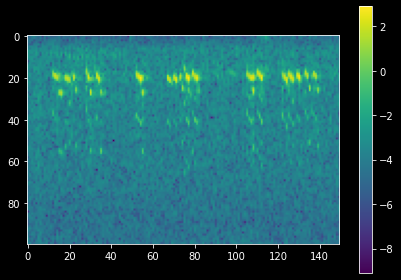

In [154]:
#plt.imshow()
#plt.colorbar()
#plt.spines['bottom'].set_color('white')
#plt.spines['left'].set_color('white')
#plt.xaxis.label.set_color('white')
#plt.tick_params(axis='x', colors='white')
#plt.tick_params(axis='colorbar', colors='white')
#plt.tick_params(axis='y', colors='white')

fig, ax1 = plt.subplots(1,1)

im = ax1.imshow(np.log(spec[:,:150,0]))#, interpolation='nearest')
cb = plt.colorbar(im)

fg_color = 'white'
bg_color = 'black'

# IMSHOW    
# set title plus title color
#ax1.set_title('ax1 title', color=fg_color)

# set figure facecolor
#ax1.patch.set_facecolor(bg_color)

# set tick and ticklabel color
im.axes.tick_params(color=fg_color, labelcolor=fg_color)

# set imshow outline
for spine in im.axes.spines.values():
    spine.set_edgecolor(fg_color)    

# COLORBAR
# set colorbar label plus label color
#cb.set_label('colorbar label', color=fg_color)

# set colorbar tick color
cb.ax.yaxis.set_tick_params(color=fg_color)

# set colorbar edgecolor 
cb.outline.set_edgecolor(fg_color)

# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)

fig.patch.set_facecolor(bg_color)    
plt.tight_layout()
plt.show()
#plt.savefig('save/to/pic.png', dpi=200, facecolor=bg_color)

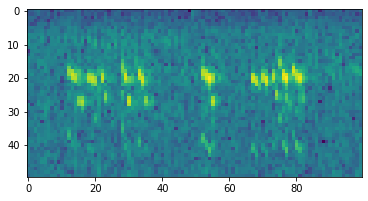

In [142]:
plt.imshow(np.log(np.mean(spec[:50,:100,1:3], axis=-1)))

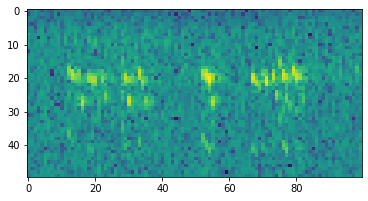

In [23]:
plt.imshow(np.log(spec[:50,:100,1]))

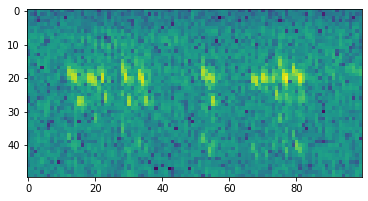

In [24]:
plt.imshow(np.log(spec[:50,:100,2]))

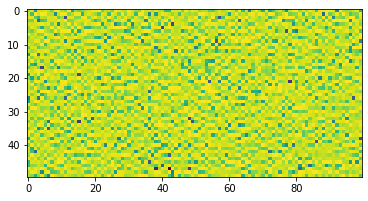

In [25]:
plt.imshow(np.log(spec[:50,:100,3]))

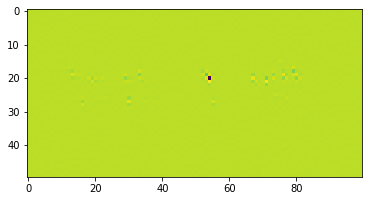

In [37]:
plt.imshow(np.log(spec[:50,:100,4]-np.min(spec[:50,:100,4])+0.1))

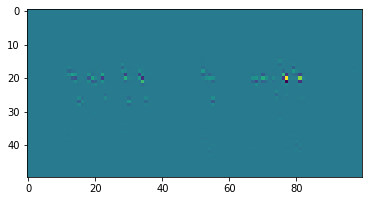

In [44]:
plt.imshow(spec[:50,:100,5]-np.min(spec[:50,:100,5]))

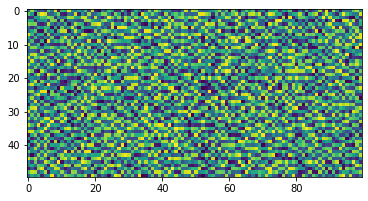

In [42]:
plt.imshow(spec[:50,:100,6])

In [26]:
#plt.imshow(np.log(np.mean(spec[:50,:100,1:3], axis=2)))
#spec[:50,:100,1:3].shape

In [27]:
#plt.imshow(np.log(spec[:50,:100,3]))

In [28]:
def spec_normalize(x):
        return tf.divide(
        tf.subtract(
            x, tf.reduce_min(x)
        ), 
        tf.subtract(
            tf.reduce_max(x), 
            tf.reduce_min(x)
        )
    )
#spec_normalize(spec)

In [48]:
#spec[:,:,3]
os.listdir()

['.ipynb_checkpoints',
 '.RData',
 '.Rhistory',
 'audio_15sec_split.ipynb',
 'audio_download-Copy1.ipynb',
 'audio_download.ipynb',
 'audio_download_dun_laoghaire .ipynb',
 'bird_classifier.ipynb',
 'bird_classifier_dl.ipynb',
 'bird_classifier_dl_split.ipynb',
 'bird_classifier_richfield.ipynb',
 'bird_classifier_richfield_mult.ipynb',
 'bird_classifier_richfield_mult_loop.ipynb',
 'bird_classifier_shallow_net.ipynb',
 'checkpoint',
 'checkpoints',
 'confusion_matrix',
 'data_set_params.py',
 'dublin_dl_birds',
 'dublin_dl_birds_split',
 'extract_run_info.R',
 'filenames',
 'kaleidoscope_results',
 'models',
 'model_history',
 'pred_df_softmax',
 'richfield_birds',
 'robin photo.jpg',
 'species list ireland - dun laoghaire.xlsx',
 'species list richfield.xlsx',
 'spec_absang.png',
 'spec_absim.png',
 'spec_absre.png',
 'spec_mod.png',
 'tf_helpers.py',
 'xeno_canto_files',
 'y_pred',
 'y_true',
 '__pycache__']

In [104]:
import cv2
robin_img = cv2.imread('robin photo.jpg')
robin_img = robin_img[:,:,::-1]

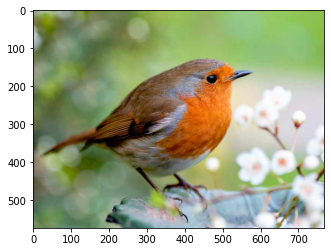

In [81]:
plt.imshow(robin_img)

In [106]:
from copy import deepcopy

In [107]:
robin_img_r = deepcopy(robin_img)
robin_img_g = deepcopy(robin_img)
robin_img_b = deepcopy(robin_img)

In [112]:
robin_img_r[:,:,1] = 0
robin_img_r[:,:,2] = 0
robin_img_g[:,:,0] = 0
robin_img_g[:,:,2] = 0
robin_img_b[:,:,0] = 0
robin_img_b[:,:,1] = 0

In [113]:
robin_img

array([[[154, 161, 128],
        [154, 161, 128],
        [153, 163, 129],
        ...,
        [138, 190,  79],
        [138, 190,  79],
        [138, 190,  79]],

       [[154, 161, 130],
        [154, 161, 128],
        [153, 162, 131],
        ...,
        [138, 190,  79],
        [138, 190,  79],
        [138, 190,  79]],

       [[154, 160, 132],
        [154, 161, 130],
        [153, 162, 133],
        ...,
        [138, 190,  79],
        [138, 190,  79],
        [138, 190,  79]],

       ...,

       [[121, 147, 100],
        [121, 147, 100],
        [120, 146,  99],
        ...,
        [239, 250, 244],
        [241, 252, 244],
        [242, 254, 244]],

       [[121, 147, 100],
        [121, 147, 100],
        [120, 146,  99],
        ...,
        [240, 251, 243],
        [241, 253, 243],
        [242, 254, 242]],

       [[121, 147, 100],
        [121, 147, 100],
        [120, 146,  99],
        ...,
        [241, 252, 244],
        [242, 254, 244],
        [243, 255, 243]]

In [114]:
#robin_img_r[:,:,1:].shape
#robin_img_g[:,:,[0,-1]].shape
#robin_img_b[:,:,:-1].shape

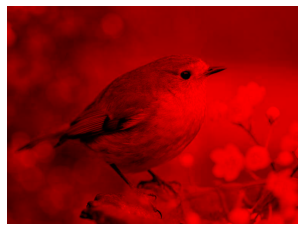

In [120]:
plt.imshow(robin_img_r)
plt.axis('off')
plt.savefig("robin_red.png", bbox_inches='tight')

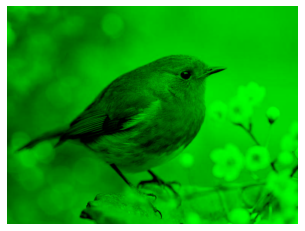

In [119]:
plt.imshow(robin_img_g)
plt.axis('off')
plt.savefig("robin_green.png", bbox_inches='tight')

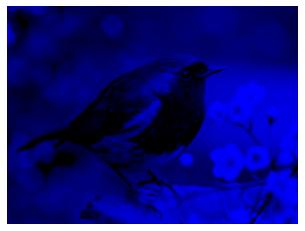

In [118]:
plt.imshow(robin_img_b)
plt.axis('off')
plt.savefig("robin_blue.png", bbox_inches='tight')

In [122]:
def preprocess_dataset_tmp(files):
    AUTOTUNE  = tf.data.experimental.AUTOTUNE
    files_ds  = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_sr_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,_ :  gen_complex_spec(x, params), num_parallel_calls=AUTOTUNE)
    return output_ds

In [123]:
complex_ds = preprocess_dataset_tmp(filenames[:30])

In [125]:
for cspec in complex_ds.take(1):
    complex_spec = cspec

In [140]:
tf.math.angle(cspec[:2,:2])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 3.1415927, -1.0918316],
       [ 0.       ,  2.1792388]], dtype=float32)>